In [6]:
!pip install duckdb
!pip install rdkit

In [7]:
import numpy as np
import pandas as pd
import duckdb
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit import RDLogger
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import time

In [8]:
train = pd.read_csv('/kaggle/input/leash-BELKA/train.csv', nrows=1000)
train.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,0,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,BRD4,0
1,1,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,HSA,0
2,2,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,sEH,0
3,3,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,BRD4,0
4,4,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,HSA,0


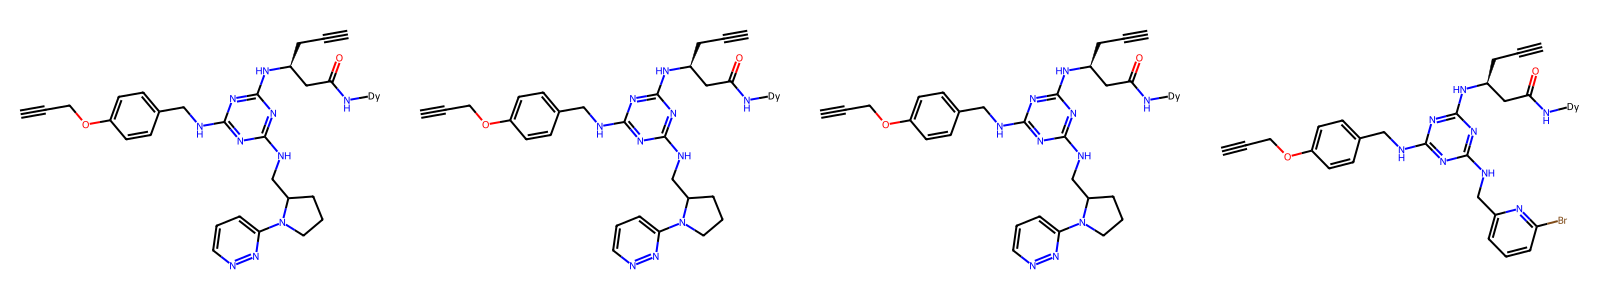

In [5]:
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in train['molecule_smiles'][0:4]], molsPerRow=4, subImgSize=(400,300))

In [9]:
train_path = '/kaggle/input/leash-BELKA/train.parquet'
test_path = '/kaggle/input/leash-BELKA/test.parquet'

con = duckdb.connect()

df = con.query(f"""(SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 0
                        ORDER BY random()
                        LIMIT 10000)
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 1
                        ORDER BY random()
                        LIMIT 10000)""").df()

con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [5]:
df.tail()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
19995,18384753,CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,Nc1ccc2c(c1)CCC2=O,COc1cc(CN)c(Br)cn1,COc1cc(CNc2nc(Nc3ccc4c(c3)CCC4=O)nc(NC(CC(C)C)...,BRD4,1
19996,248760282,O=C(O)C[C@@H](Cc1ccc(F)cc1)NC(=O)OCC1c2ccccc2-...,Cc1cc(N)ccc1F,COc1nc(C)ccc1CN,COc1nc(C)ccc1CNc1nc(Nc2ccc(F)c(C)c2)nc(N[C@@H]...,BRD4,1
19997,252544422,O=C(O)C[C@@H](Cc1cccc(F)c1)NC(=O)OCC1c2ccccc2-...,Nc1cc(N2CCNCC2)ccc1[N+](=O)[O-],Nc1nnn[nH]1,O=C(C[C@@H](Cc1cccc(F)c1)Nc1nc(Nc2nnn[nH]2)nc(...,BRD4,1
19998,158442127,O=C(Nc1cc(Br)c(F)cc1C(=O)O)OCC1c2ccccc2-c2ccccc21,Cl.Cl.NCC=Cc1cccnc1,COC(=O)c1cncc(N)c1,COC(=O)c1cncc(Nc2nc(NCC=Cc3cccnc3)nc(Nc3cc(Br)...,HSA,1
19999,228781272,O=C(Nc1nc2ncc(CNc3ccc(C(=O)O)cc3)nc2c(=O)[nH]1...,Nc1ncncc1Br,Cl.Cl.NCC(O)c1ccncc1,O=C(N[Dy])c1ccc(NCc2cnc3nc(Nc4nc(NCC(O)c5ccncc...,BRD4,1


In [10]:
df["protein_name"].value_counts()

protein_name
sEH     7932
BRD4    6202
HSA     5866
Name: count, dtype: int64

## Преобразование строкового представления молекул в формате SMILES в объекты молекул RDKit. 
Формат SMILES (Simplified Molecular Input Line Entry System) представляет собой текстовый формат для описания структуры химических молекул. RDKit предоставляет инструменты для работы с молекулами, такие как визуализация, расчет химических свойств и генерация молекулярных отпечатков.
ECFP (также известные как отпечатки пальцев Моргана) — это численные представления молекул, используемые для захвата их структурных особенностей. Эти отпечатки создаются путем итеративного рассмотрения атомных окружений в молекуле и кодирования их в битовые векторы. Они полезны для различных задач, включая поиск похожих молекул, кластеризацию, классификацию и докинг. В данном случае, generate_ecfp создает битовый вектор для каждой молекулы с использованием радиуса 2 и длины вектора 1024 бита.
Используя ECFP, можно легко сравнивать молекулы и анализировать их сходства и различия.

Радиус (radius=2)
Радиус определяет, насколько далеко от каждого атома в молекуле нужно искать окружение, чтобы включить его в отпечаток. В данном случае радиус 2 означает, что учитываются атомы и связи на расстоянии до двух шагов от каждого атома (то есть центральный атом, его непосредственные соседи и соседи этих соседей).

Выбор радиуса 2 является компромиссом между детализацией и сложностью: считается достаточно информативным для захвата ключевых структурных особенностей молекулы без чрезмерного увеличения размерности данных. Это позволяет эффективно отличать разные молекулы и классифицировать их.
Меньшие значения радиуса могут не захватить важные структурные особенности молекулы.
Большие значения радиуса могут захватить слишком много деталей, что может привести к избыточности и усложнению анализа.
Длина вектора (bits=1024)
Длина битового вектора определяет, сколько битов будет в отпечатке. В данном случае используется 1024 бита.

Выбор длины вектора в 1024 бита тоже является компромиссом: считается хорошим балансом между пространственными затратами и разрешающей способностью. Это позволяет представлять молекулы достаточно детализированно, чтобы различать их, но при этом сохранять управляемый размер данных.
Меньшие значения битов могут привести к потерям информации и увеличению вероятности коллизий (разные молекулы могут иметь одинаковые отпечатки).
Большие значения битов могут обеспечить больше информации, но увеличат объем данных и вычислительную нагрузку.
Эти значения (radius=2 и bits=1024) широко используются в литературе и на практике, потому что они дают хороший компромисс между детализацией, точностью и вычислительной эффективностью.

In [11]:
%%time

# Convert SMILES to RDKit molecules
df['molecule'] = df['molecule_smiles'].apply(Chem.MolFromSmiles)

# Generate ECFPs
def generate_ecfp(molecule, radius=2, bits=1024):
    if molecule is None:
        return None
    return list(AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=bits))

df['ecfp'] = df['molecule'].apply(generate_ecfp)

CPU times: user 28.2 s, sys: 421 ms, total: 28.6 s
Wall time: 28.6 s


In [7]:
print(df['ecfp'].head())

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: ecfp, dtype: object


In [12]:
# Проверка на наличие дубликатов по SMILES
duplicate_smiles = df[df.duplicated('molecule_smiles')]['molecule_smiles'].unique()
print("Количество уникальных дубликатов SMILES:", len(duplicate_smiles))

Количество уникальных дубликатов SMILES: 8


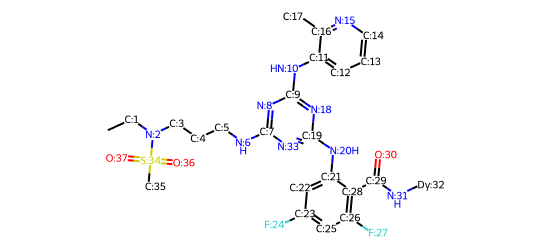

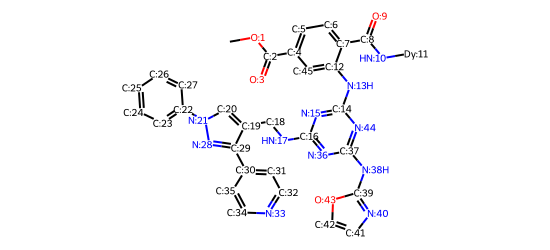

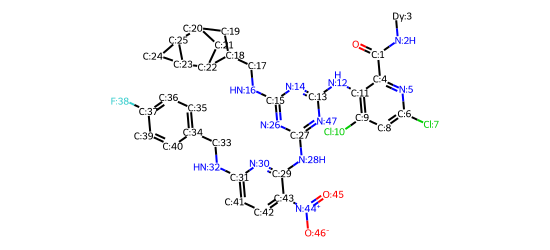

In [13]:
# Визуализация молекул с атомными индексами
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

# Визуализация первых пяти молекул
for idx, row in df.head(3).iterrows():
    mol = mol_with_atom_index(row['molecule'])
    drawer = Draw.MolDraw2DSVG(550, 250)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    display(SVG(svg.replace('svg:', '')))

In [11]:
df.head(2)

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds,molecule,ecfp
0,154101786,O=C(Nc1c(I)cccc1C(=O)O)OCC1c2ccccc2-c2ccccc21,Cl.Cl.NC[C@@H]1CCO[C@H]1c1cn[nH]c1,Nc1ncc(Cl)cc1F,O=C(N[Dy])c1cccc(I)c1Nc1nc(NC[C@@H]2CCO[C@H]2c...,BRD4,0,<rdkit.Chem.rdchem.Mol object at 0x7ebd6a9e94d0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,25857622,CN(C(=O)OCC1c2ccccc2-c2ccccc21)[C@@H](CC1CCCCC...,NCc1cc(-c2ccccc2)[nH]n1,Cl.NCC12CC3CC(CC(C3)C1)C2,CN(c1nc(NCc2cc(-c3ccccc3)[nH]n2)nc(NCC23CC4CC(...,HSA,0,<rdkit.Chem.rdchem.Mol object at 0x7ebd6a9e92a0>,"[0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
all_blocks = pd.concat([df.buildingblock1_smiles, df.buildingblock2_smiles, df.buildingblock3_smiles])

all_blocks.value_counts().head(20)

O=C(NCC1CCC(C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21            1640
O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21    1097
Cl.Cl.NCc1cncc(F)c1                                       504
Cc1cc2cc(CN)ccc2[nH]1                                     427
Nc1cc(N2CCNCC2)ccc1[N+](=O)[O-]                           394
Cl.Cn1cc(N)ccc1=O                                         368
CCOC(=O)c1ncccc1N                                         274
CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O               260
Nc1ccc2c(c1)CNC2=O                                        259
CC(OC(C)(C)C)C(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O        257
Cl.NCc1cnc2n1CCOC2                                        222
O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21            221
Cl.Cl.NCc1ccc(O)c2ncccc12                                 221
NCCC1CSC1                                                 211
O=C(Nc1ccc(C(=O)O)cc1)OCC1c2ccccc2-c2ccccc21              204
COC(=O)c1cncc(N)c1                                        196
Nc1ccc(C

In [15]:
%%time

import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
import lightgbm as lgb

# One-hot encode the protein_name
onehot_encoder = OneHotEncoder(sparse_output=False)
protein_onehot = onehot_encoder.fit_transform(df['protein_name'].values.reshape(-1, 1))

# Combine ECFPs and one-hot encoded protein_name
X = [ecfp + protein for ecfp, protein in zip(df['ecfp'].tolist(), protein_onehot.tolist())]
y = df['binds'].tolist()

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]  # Probability of the positive class
map_score_rf = average_precision_score(y_test, y_pred_proba_rf)
print(f"RandomForest Mean Average Precision (mAP): {map_score_rf:.2f}")

# XGBClassifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:,1]
map_score_xgb = average_precision_score(y_test, y_pred_proba_xgb)
print(f"XGBoost Mean Average Precision (mAP): {map_score_xgb:.2f}")

# LightGBM
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgb_model.fit(X_train, y_train)
y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]  # Probability of the positive class
map_score_lgb = average_precision_score(y_test, y_pred_proba_lgb)
print(f"LightGBM Mean Average Precision (mAP): {map_score_lgb:.2f}")

RandomForest Mean Average Precision (mAP): 0.96
XGBoost Mean Average Precision (mAP): 0.96
LightGBM Mean Average Precision (mAP): 0.96
CPU times: user 36.9 s, sys: 710 ms, total: 37.6 s
Wall time: 27.8 s


In [16]:
%%time
predict_test = (rf_model.predict_proba(X_test)[:, 1] * 0.30) + (xgb_model.predict_proba(X_test)[:, 1] * 0.30) + (lgb_model.predict_proba(X_test)[:, 1] * 0.40)
score = average_precision_score(y_test, predict_test) 
score

CPU times: user 1.73 s, sys: 4.99 ms, total: 1.73 s
Wall time: 1.58 s


0.9626540910171183

In [17]:
%%time

# Определяем функцию для генерации ECFP
def generate_ecfp(molecule, radius=2, bits=1024):
    if molecule is None:
        return None
    return list(AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=bits))

test_file = '/kaggle/input/leash-BELKA/test.csv'
sample_submission_file = '/kaggle/input/leash-BELKA/sample_submission.csv'
output_file = 'submission.csv'
df_test = pd.read_csv(test_file, nrows=10000)

# Генерируем ECFP для molecule_smiles
df_test['molecule'] = df_test['molecule_smiles'].apply(Chem.MolFromSmiles)
df_test['ecfp'] = df_test['molecule'].apply(generate_ecfp)

# One-hot encode the protein_name
onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoder.fit(df['protein_name'].values.reshape(-1, 1))
protein_onehot_test = onehot_encoder.transform(df_test['protein_name'].values.reshape(-1, 1))

# Объединяем ECFP и one-hot закодированные данные
X_test = [ecfp + protein for ecfp, protein in zip(df_test['ecfp'].tolist(), protein_onehot_test.tolist())]

# Прогнозируем вероятности с использованием ансамбля моделей
predict_test = (rf_model.predict_proba(X_test)[:, 1] * 0.30) + \
               (xgb_model.predict_proba(X_test)[:, 1] * 0.30) + \
               (lgb_model.predict_proba(X_test)[:, 1] * 0.40)

# Загружаем sample_submission.csv
output_df = pd.read_csv(sample_submission_file)

# Обновляем первые 10,000 строк в sample_submission.csv нашими прогнозами
output_df.loc[0:9999, 'binds'] = predict_test

# Сохраняем обновленный файл
output_df.to_csv(output_file, index=False)

CPU times: user 22.4 s, sys: 314 ms, total: 22.7 s
Wall time: 22.6 s


In [18]:
output_df

,id,binds
0,295246830,0.427833
1,295246831,0.258538
2,295246832,0.212215
3,295246833,0.640593
4,295246834,0.435226
...,...,...
1674891,296921721,0.500000
1674892,296921722,0.500000
1674893,296921723,0.500000
1674894,296921724,0.500000


In [19]:
submission_df = pd.read_csv(output_file)
print(submission_df.head())

          id     binds
0  295246830  0.427833
1  295246831  0.258538
2  295246832  0.212215
3  295246833  0.640593
4  295246834  0.435226


In [21]:
df_sample_submission = pd.read_csv(sample_submission_file)
print(df_sample_submission.head())

          id  binds
0  295246830    0.5
1  295246831    0.5
2  295246832    0.5
3  295246833    0.5
4  295246834    0.5
